# House Prices - Advanced Regression Techniques
> Original code : [Advanced Regression Techniques(Regularization) by ALFRED](https://www.kaggle.com/code/alfredmaboa/advanced-regression-techniques-regularization#Start-Model-Building)

## Data field
#### **SalePrice: target($)**  

**MSSubClass** : The building class | **MSZoning** : The general zoning classification  
**LotFrontage** : Linear feet of street connected to property | **otArea** : Lot size in square feet | **LotShape** : General shape of property  
**Street** : Type of road access | **Alley** : Type of alley access  
**LandContour** : Flatness of the property | **Utilities** : Type of utilities available  
**LotConfig** : Lot configuration | **LandSlope** : Slope of property | **Neighborhood** : Physical locations within Ames city limits  
**Condition1** : Proximity to main road or railroad | **Condition2** : Proximity to main road or railroad (if a second is present)  
**BldgType** : Type of dwelling | **HouseStyle** : Style of dwelling  
**verallQua** : Overall material and finish quality | **OverallCond** : Overall condition rating  
**YearBuilt** : Original construction date | **YearRemodAdd** : Remodel date  
**RoofStyle** : Type of roof | **RoofMatl** : Roof material  
**Exterior1st** : Exterior covering on house | **Exterior2nd** : Exterior covering on house (if more than one material)  
**MasVnrType** : Masonry veneer type | **MasVnrArea** : Masonry veneer area in square feet  
**ExterQual** : Exterior material quality | **ExterCond** : Present condition of the material on the exterior  
**Foundation** : Type of foundation | **BsmtQual** : Height of the basement | **BsmtCond** : General condition of the basement  
**BsmtExposure** : Walkout or garden level basement walls | **BsmtFinType1** : Quality of basement finished area | **BsmtFinSF1** : Type 1 finished square feet  
**BsmtFinType2** : Quality of second finished area (if present) | **BsmtFinSF2** : Type 2 finished square feet | **BsmtUnfSF** : Unfinished square feet of basement area  
**TotalBsmtSF** : Total square feet of basement area | **Heating** : Type of heating | **HeatingQC** : Heating quality and condition  
**CentralAir** : Central air conditioning | **Electrical** : Electrical system  
**1stFlrSF** : First Floor square feet | **2ndFlrSF** : Second floor square feet  
**LowQualFinSF** : Low quality finished square feet (all floors) | **GrLivArea** : Above grade (ground) living area square feet  
**BsmtFullBath** : Basement full bathrooms | **BsmtHalfBath** : Basement half bathrooms  
**FullBath** : Full bathrooms above grade | **HalfBath** : Half baths above grade  
**Bedroom** : Number of bedrooms above basement level | **Kitchen** : Number of kitchens | **KitchenQual** : Kitchen quality  
**TotRmsAbvGrd** : Total rooms above grade (does not include bathrooms) | **Functional** : Home functionality rating | **Fireplaces** : Number of fireplaces  
**FireplaceQu** : Fireplace quality | **GarageType** : Garage location | **GarageYrBlt** : Year garage was built  
**GarageFinish** : Interior finish of the garage | **GarageCars** : Size of garage in car capacity | **GarageArea** : Size of garage in square feet  
**GarageQual** : Garage quality | **GarageCond** : Garage condition | **PavedDrive** : Paved driveway  
**WoodDeckSF** : Wood deck area in square feet | **OpenPorchSF** : Open porch area in square feet | **nclosedPorch** : Enclosed porch area in square feet  
**3SsnPorch** : Three season porch area in square feet | **ScreenPorch** : Screen porch area in square feet | **PoolArea** : Pool area in square feet  
**PoolQC** : Pool quality | **Fence** : Fence quality | **MiscFeature** : Miscellaneous feature not covered in other categories  
**MiscVal** : Value of miscellaneous feature | **MoSold** : Month Sold | **YrSold** : Year Sold  
**SaleType** : Type of sale | **SaleCondition** : Condition of sale

## 1. Import Libraries

In [1]:
# linear algebra, data handling, visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# modeling
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

## 2. Import Dataset

In [2]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

In [3]:
train.head()

In [4]:
test.head()

## 3. Data preprocessing

In [5]:
train_id = train['Id']
test_id = test['Id']

# drop the 'ID' column -> no need for training
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

In [6]:
train.head()

- Distribution of the target to see if it fits a normal distribution,due to the parametric nature

In [20]:
# Before normalization

sns.set_style("white")
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (8, 6))

sns.distplot(train['SalePrice'], color = 'b')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

sns.despine(trim=True, left=True)  # delete border
plt.show()

- skewed to the right
  - apply log(1+x) to all elements of the column which fixes the skeweness of the distribution.

In [21]:
train["SalePrice"] = np.log1p(train["SalePrice"])

# new distribution
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'] , fit=norm, color="b");  # plotting with normal distribution (black line)

- Check fitted parameters of normal distribution

In [22]:
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

In [23]:
# target
y = train.SalePrice.reset_index(drop=True)
y

In [25]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# concatinate the train and the test set as features for tranformation to avoid mismatch
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [26]:
print('Features size:', features.shape)

## 4. Feature Engineering

### 4-(1). Missing values

In [27]:
# determining the threshold of missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

In [30]:
f, ax = plt.subplots(figsize=(8, 7))
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")

ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [32]:
features['Exterior1st'].mode()[0]

In [33]:
# Some of the non-numeric predictors are stored as numbers --> we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# data description says NA means typical
features['Functional'] = features['Functional'].fillna('Typ')

# one NA value. We set 'SBrkr' (which is the most frequent)
features['Electrical'] = features['Electrical'].fillna("SBrkr")
# one NA value, We set 'TA' (which is the most frequent)
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

# one NA value. We substitute in the most common string
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

# Fill with most frequent one
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# data description says NA means "No Pool" (majority of houses have no Pool at all in general.)
features["PoolQC"] = features["PoolQC"].fillna("None")

# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
    
# Replacing missing data with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
    
# For all these categorical basement-related features, NaN means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

# Fill with most frequent 'RL'
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

print('Features size:', features.shape)  # no change -> dropping X

In [37]:
features.isnull().sum().sum()

In [38]:
# Filling the rest of the categorical features (String)
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [39]:
# Filling in the rest of the NA's (numeric)
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [40]:
# Check the remaining missing values
missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

- No more missing values

### 4-(2). More feature engineering

In [41]:
# We need to find all numeric features in the data
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [42]:
# Box plots for all our numeric features
f, ax = plt.subplots(figsize=(16, 14))
ax.set_xscale("log")

ax = sns.boxplot(data=features[numerics2] , orient="h", palette="Set1")

ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

- some data that is not normaly distributed (Skewed)

In [43]:
# Calculate the skewness
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

#### Box-cox transformation
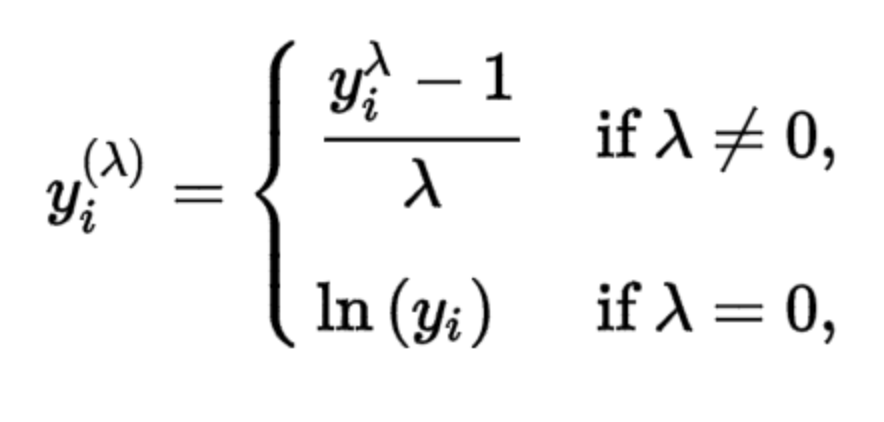  
- simple transformation that leads to normality.

In [45]:
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [46]:
f, ax = plt.subplots(figsize=(16, 14))
ax.set_xscale("log")

ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")

ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

- `MasVnrArea`, `OpenPorchSF`, `WoodDeckSF`, `BsmtFinSF1`, `2ndFlrSF` could not be normalized -> dropping
  - Since `area` related features are very important to determine house prices
  - Add `total area of floors`, `bathrooms` and `porch area` before dropping  


- `MasVnrArea` : Masonry veneer area in square feet | `penPorchSF` : Open porch area in square feet
- `WoodDeckSF` : Wood deck area in square feet | `BsmtFinSF1` : Type 1 finished square feet

  

In [47]:
# Calculating totals before droping less significant columns

#  Adding total sqfootage feature 
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

#  Adding total bathrooms feature
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
#  Adding total porch sqfootage feature
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [48]:
# dropping
features = features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)

In [49]:
# Adding new simplified features (1 = present, 0 = not present)
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print('Features size:', features.shape)

In [68]:
# One-hot Encoding the finalized features
final_features = pd.get_dummies(features).reset_index(drop=True)

print('Features size after one-hot encoding:', final_features.shape)

In [69]:
features['Street'].unique()

In [70]:
final_features[['Street_Pave', 'Street_Grvl']].head()

In [74]:
# Spliting train and test

X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(X):, :]

print('Shape of train X', X.shape)
print('Shape of train y', y.shape)
print('Shape of test X', X_test.shape)

In [75]:
# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print('Shape of train X', X.shape)
print('Shape of train y', y.shape)
print('Shape of test X', X_test.shape)

## 5. Modeling

### Linear regression
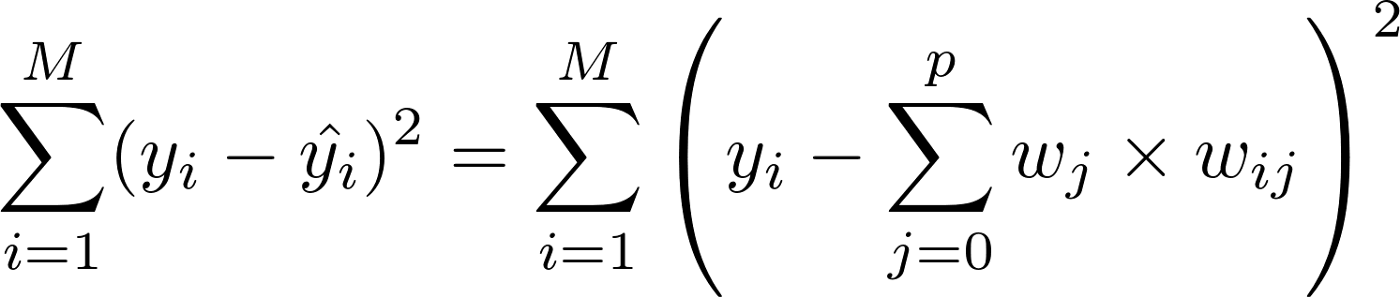  

### Ridge regression
- L2 penalty term.

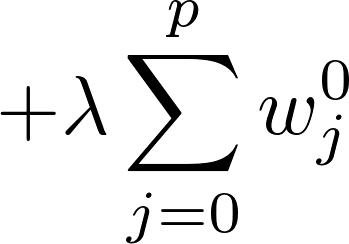

### Lasso regression
- L1 penalty term

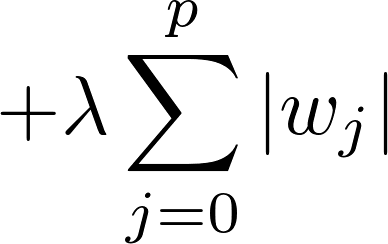

### Elastic net
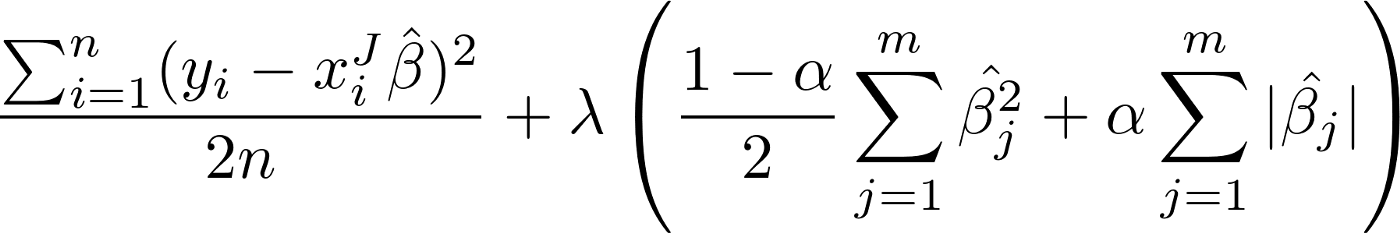

- kfolds Cross Validation function where K=10

In [76]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

- RidgeCV, LassoCV, ElasticNetCV

In [77]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet}
predictions = {}
scores = {}

for name, model in models.items():
    
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

- 10-fold stacking
  - we first split the training data into 10 folds. Then we will do 10 iterations. 
  - In each iteration, we train every base model on 9 folds and predict on the remaining fold (holdout fold).

In [78]:
# evaluation

print('---- Score with CV_RMSLE-----')

score = cv_rmse(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [79]:
# Fit the train dataset
print('----START Fit----',datetime.now())

print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)

In [132]:
f, ax = plt.subplots(figsize=(8, 7))
sns.set_style("white")

model_name = 'Ridge'
plt.scatter(predictions[model_name], np.expm1(y))
plt.plot([0, 800000], [0, 800000], '--r')

plt.xlabel(model_name +' Predictions (y_pred)', size=10)
plt.ylabel('Real Values (y_train)', size=10)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.title(model_name +' Predictions vs Real Values', size=13)
plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model_name][0], scores[model_name][1]), fontsize=10)
ax.xaxis.grid(False)
sns.despine(trim=True, left=True)
plt.show()

In [131]:
f, ax = plt.subplots(figsize=(8, 7))
sns.set_style("white")

model_name = 'Lasso'
plt.scatter(predictions[model_name], np.expm1(y))
plt.plot([0, 800000], [0, 800000], '--r')

plt.xlabel(model_name +' Predictions (y_pred)', size=10)
plt.ylabel('Real Values (y_train)', size=10)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.title(model_name +' Predictions vs Real Values', size=13)
plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model_name][0], scores[model_name][1]), fontsize=10)
ax.xaxis.grid(False)
sns.despine(trim=True, left=True)
plt.show()

In [130]:
f, ax = plt.subplots(figsize=(8, 7))
sns.set_style("white")

model_name = 'ElasticNet'
plt.scatter(predictions[model_name], np.expm1(y))
plt.plot([0, 800000], [0, 800000], '--r')

plt.xlabel(model_name +' Predictions (y_pred)', size=10)
plt.ylabel('Real Values (y_train)', size=10)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.title(model_name +' Predictions vs Real Values', size=13)
plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model_name][0], scores[model_name][1]), fontsize=10)
ax.xaxis.grid(False)
sns.despine(trim=True, left=True)
plt.show()

#### Ensemble prediction on blended models

In [94]:
def blend_models(X):
    return ((elastic_model.predict(X)) + (lasso_model.predict(X)) + (ridge_model.predict(X)))/3

blended_score = rmsle(y, blend_models(X))
print('RMSLE score on train data:')
print(rmsle(y, blend_models(X)))

In [128]:
f, ax = plt.subplots(figsize=(8, 7))
sns.set_style("white")

plt.scatter(np.expm1(blend_models(X)), np.expm1(y))
plt.plot([0, 800000], [0, 800000], '--r')

plt.xlabel('Ensemble Predictions (y_pred)', size=10)
plt.ylabel('Real Values (y_train)', size=10)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.title('Ensemble Predictions vs Real Values', size=13)
plt.text(0, 700000, 'RMSE: {:.6f}'.format(rmsle(y, blend_models(X))), fontsize=10)
ax.xaxis.grid(False)
sns.despine(trim=True, left=True)
plt.show()

In [96]:
y_test_r = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

y_test = np.log1p(y_test_r.iloc[:,1].values)
submission.iloc[:,1] = np.expm1(blend_models(X_test))
blended_score = rmsle(y_test, blend_models(X_test))

In [97]:
submission.head()

In [98]:
submission.to_csv("submission.csv", index=False)